In [ ]:
import kagglehub

path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 121M/121M [00:01<00:00, 69.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1


In [6]:
path = "/root/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1/images"
files = os.listdir(path)

print("Files and folders in the dataset:", files)


Files and folders in the dataset: ['images', 'train', 'validation']


In [5]:
#dependencies
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


In [7]:
# validation is for testing
DIR_train = path + '/train'
DIR_test = path + '/validation'
def generateDF(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for image_name in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,image_name))
            labels.append(label)
        print(label," Completed")
    return image_paths,labels

In [8]:
# generate the DF for training
train = pd.DataFrame()
train['image'], train['label'] = generateDF(DIR_train)


fear  Completed
neutral  Completed
disgust  Completed
surprise  Completed
angry  Completed
sad  Completed
happy  Completed


In [9]:
train

,image,label
0,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
1,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
2,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
3,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
4,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
...,...,...
28816,/root/.cache/kagglehub/datasets/jonathanoheix/...,happy
28817,/root/.cache/kagglehub/datasets/jonathanoheix/...,happy
28818,/root/.cache/kagglehub/datasets/jonathanoheix/...,happy
28819,/root/.cache/kagglehub/datasets/jonathanoheix/...,happy


In [10]:
# generate the DF for test
test = pd.DataFrame()
test['image'], test['label'] = generateDF(DIR_test)

fear  Completed
neutral  Completed
disgust  Completed
surprise  Completed
angry  Completed
sad  Completed
happy  Completed


In [11]:
test

,image,label
0,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
1,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
2,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
3,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
4,/root/.cache/kagglehub/datasets/jonathanoheix/...,fear
...,...,...
7061,/root/.cache/kagglehub/datasets/jonathanoheix/...,happy
7062,/root/.cache/kagglehub/datasets/jonathanoheix/...,happy
7063,/root/.cache/kagglehub/datasets/jonathanoheix/...,happy
7064,/root/.cache/kagglehub/datasets/jonathanoheix/...,happy


In [12]:
# function to extract specific features from images
def get_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,color_mode="grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [13]:
train_feats = get_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [14]:
test_feats = get_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [15]:
# normalize the feature values from [0, 255] to [0, 1]
x_train = train_feats/255
x_test = test_feats/255

In [16]:
# label encoder scans the unique labels and assigns them a unique integer value
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()
lbl_enc.fit(train['label'])

LabelEncoder()

In [17]:
y_train = lbl_enc.transform(train['label'])
y_test = lbl_enc.transform(test['label'])
# one hot encoding format
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [18]:
model = Sequential()

# adding convulation layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# connecting the layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(x=x_train,y=y_train, batch_size=128,epochs=100,validation_data=(x_test, y_test))

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.2295 - loss: 1.8468 - val_accuracy: 0.2583 - val_loss: 1.8127
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.2449 - loss: 1.8119 - val_accuracy: 0.2562 - val_loss: 1.7645
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.2685 - loss: 1.7560 - val_accuracy: 0.3530 - val_loss: 1.6282
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3357 - loss: 1.6507 - val_accuracy: 0.4403 - val_loss: 1.5075
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3947 - loss: 1.5477 - val_accuracy: 0.4659 - val_loss: 1.3917
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.4291 - loss: 1.4719 - val_accuracy: 0.4975 - val_loss: 1.3299
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.4651 - loss: 1.3947 - val_accuracy: 0.5140 - val_loss: 1.2746
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.4761 - loss: 1

In [22]:
model_json = model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

model.save("emotion_model.keras")

In [24]:
from keras.models import model_from_json
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("emotion_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
label = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
def get_feature_from_one(image):
    img = load_img(image,color_mode="grayscale")
    img = np.array(img)
    img = img.reshape(1,48,48,1)
    return img/255

In [27]:
# general prediction on training
image = path + '/train/angry/22.jpg'
print("Original: angry")
feat_img = get_feature_from_one(image)
prediction = loaded_model.predict(feat_img)
prediction_label = label[np.argmax(prediction)]
print("Predicted: ",label[np.argmax(prediction)])

Original: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted:  angry


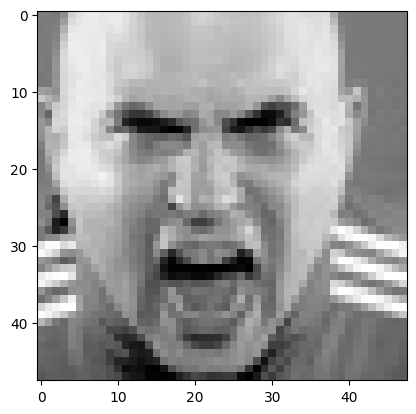

In [29]:
# to plot
import matplotlib.pyplot as plt
plt.imshow(feat_img[0], cmap='gray')
plt.show()

In [ ]:
# end of notebookkkkkk!!!!!!!!!!!!!